#IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT 5 - Structured Tune variations

This is part 5 of the ongoing investigation into the preservation of the invariants through the nonlinear element in Synergia. See [Part 1 - Comparing Full Chef to Linear Dynamics](IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT1 - Comparing Full chef to linear dynamics.ipynb) for a look at how the nonlinear aspects of "linear" lattice elements may affect the invariant. See [Part 2 -  Slicing the Nonlinear Magnet in MADX](IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT 2 - Increasing the magnet slices.ipynb) for a look at how further refinement/slicing of the nonlinear magnet can influence the particle motion. See [Part 3 - Changing the Tune](IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT 3 - Changing the tune through the NLL magnet.ipynb) to see how increasing the tune through the NLL element increases the spread in the invariant for a test particle. See [Part 4 - Increased tune through the NL magnet with larger bunches](IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT 4 - Full Matched Bunches with Larger Tune) to see the verfication of an increase in spread in the invariant with a full matched bunch.

The testing in part 1 showed a strong reduction in the number of outliers from our bunch (those particles with extremely large deviations from the mean invariant over the 100 turns). The result was a significant reduction in the standard deviation of the 2nd invariant - from ~16% down to 3% - and an additional reduction in the Hamiltonian (1st invariant) - from 3.1% down to 2.4%. 

The testing in part 2 made clear that the nonlinear potential is well described using 20 total slices. Increasing the number of slices to 40 made very little difference in the statistical spread of the single particle invariants, as the mean values remained the same, and standard deviations of 2.4% in H and 3.1% in I remained.

The basis for the testing in part 3 was the notion that the nonlinear Hamiltonian specified by the IOTA lattice is not fully integrable, and that higher order terms from the complete transfer map through the potential have $O(\nu^3)$ dependence on the tune through the NLL magnets. I constructed a new NLL magnet section with 2x the tune ($\nu = 0.6$) and derived an R-matrix to complete the new toy lattice. Basic simulations with a single particle showed an increase in the standard deviations, to 8.4% in H, and 11.6% in I.

Part 4 extended the testing in part 3 to simulate an entire bunch with generalized emittance $10^{-5}$. A similarly large spread in the Hamiltonian was seen (10.6%) while the 2nd invariant behaved very poorly, with a mean spread of ~50%.


####Execution
**For this notebook, we will consider a series of NL elements with a range of phase advances between 0.1 and 0.9** I will construct these elements using madx and subsequently calculate an R-matrix and the appropriate twiss functions for the entrance and exit of the drift.

I will aim to scale the length of each element according to the total phase advance. For each element, I will simulate three individual particles with single particle emittance values differing by an order of magnitude:  I will run with for ~100 turns.

The figure of merit will be still be the quantity $\sigma H/H_0$, where $H_0$ is the mean value of the Hamiltonian for each test particle. I will take a look at the 2nd invariant as well, but this is less important for this particular exercise.

In [127]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 18/08/2015 

CPython 2.7.10
IPython 3.1.0


In [2]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from elliptic import EllipticBeam6D
from base_diagnostics import lfplot

In [3]:
lattice = synergia.lattice.MadX_reader().get_lattice("base", "/Users/ncook/Synergia_Tests/lattices/6-6_nll_toy/nll_40slices_0pt1_tune.madx")
#lattice2 = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_1IO_center.madx")


for elem in lattice.get_elements():
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")

nsteps_per_element = 10
nsteps = len(lattice.get_elements())*nsteps_per_element
        
name = 'Tune_Test'
order = 1
tune = 0.1
outputdir = name + '_' + str(tune)

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.macro_particles=3
#opts.emitx = 1.0e-5
workflow.make_path(outputdir)


stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

#stepper2 = synergia.simulation.Independent_stepper_elements(lattice2, opts.map_order, opts.steps_per_element)
#lattice_simulator2 = stepper2.get_lattice_simulator()

Now I need to construct a loop which goes through each of the files and constructs R-matrices for each? Then I can run the simulation such that it goes through all 9 one at a time, outputs diagnostics, and calculates shit. The goal would be to have all of the data in one table to be accessible through python?

I also need to adapt my scripts to construct three particles at 3 distinct generalized emittances, such that they are the same particles every time. I can do this by specifiying a seed for Stephen's script, or by writing my own thing. I should probably write my own so that I understand it properly.

In [3]:
def get_lattice_files(relpath):
    lfiles = []
    files = os.listdir(relpath)
    
    for filename in files:
        if filename.find('nll_40slices') > -1 and filename.endswith('.madx'):
            lfiles.append(filename)
    return lfiles
    

In [4]:
def get_base_nll(nn, l0, mu0, t, c):
    '''Construct the nonlinear element. Taken from madx script by A. Valishev. 
    Verified by David's python script for pyOrbit.
    
    '''
    #musect=mu0+0.5;
    f0=l0/4.0*(1.0+1.0/np.tan(np.pi*mu0)**2); #focal length
    betae=l0/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #entrance beta function
    alphae=l0/2.0/f0/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #entrance alpha function
    betas=l0*(1-l0/4.0/f0)/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #middle beta function
    #value,f0,betae,alfae,betas;
    
    return [f0, betae,alphae,betas]

In [5]:
class Pickle_helper:
    __getstate_manages_dict__ = 1
    def __init__(self, *args):
        self.args = args
    def __getinitargs__(self):
        return self.args
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, state):
        self.__dict__ = state

class turn_actions(synergia.simulation.Propagate_actions, Pickle_helper):
    def __init__(self, mat):
        synergia.simulation.Propagate_actions.__init__(self)
        Pickle_helper.__init__(self, mat)
        self.matrix = mat #R-matrix being imported
    def turn_end_action(self, stepper, bunch, turn_num):
        '''Move particles through a single drift and advance the reference particle by the drift length'''
        
        #define matrix
        R_matrix = self.matrix
        
        particles = bunch.get_local_particles();
        for particle in particles:
            new_particle = np.dot(R_matrix,particle[0:6]) #This is for full 6x6 multiplication, not using currently.
            
            #just perform x+y-plane updates
            #new_particle = np.zeros(6)
            #new_particle[0:2] = np.dot(R_matrix[0:2,0:2],particle[0:2])
            #new_particle[2:4] = np.dot(R_matrix[2:4,2:4],particle[2:4])
            particle[0:6] = new_particle

In [5]:
def toyEllipticalBeam(opts, emits):
    
    '''
    Constructs a toy beam consisting of 3 particles total, each one at different emittances.
    Arguments:
        opts - Options class
        emits - an array of emittances.

     '''
    
    #read in the file and construct a synergia bunch
    particles_file = "myBunch{}.txt".format(opts.tune)
    comm = synergia.utils.Commxx(True)
    #bucket_length = opts.lattice_simulator.get_bucket_length()
    bucket_length = 0.05 #potential workaround
    
    for emit in emits:
        opts.macro_particles = 1
        opts.emit_transverse = emit
        #construct bunch array and write it to a textfile
        particle = EllipticalPart6D(opts)


    myBunch = read_bunch.read_bunch(particles_file, ref, opts.real_particles, bucket_length, comm, verbose=False)
    
    return myBunch

In [128]:
opts.seed

349250524

In [7]:
from base_diagnostics import latticework
#Construct R-matrices

lattice_folder = '/Users/ncook/Synergia_Tests/lattices/6-6_nll_toy/'
latticefiles = get_lattice_files(lattice_folder)
simulations = {} #construct a dictionary

In [131]:
from base_diagnostics import workflow
from base_diagnostics import latticework
from base_diagnostics import elliptic_sp
from elliptic import EllipticBeam6D
#Construct R-matrices

lattice_folder = '/Users/ncook/Synergia_Tests/lattices/6-6_nll_toy/'
latticefiles = get_lattice_files(lattice_folder)
simulations = {} #construct a dictionary

for latticefile in latticefiles[2:]:
    lattice = synergia.lattice.MadX_reader().get_lattice("base", os.path.join(lattice_folder,latticefile))
    name = latticefile[-14:-5]
    tune = int(name[3])/10. 
    
    
    for elem in lattice.get_elements():
        if elem.get_type() == 'nllens':
            elem.set_string_attribute("extractor_type", "chef_propagate")

    nsteps_per_element = 10
    nsteps = len(lattice.get_elements())*nsteps_per_element
    order = 1
    
    outputdir = name
    opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
    opts.macro_particles = 1
    opts.tracked_particles = 1
    opts.emits = [1.0e-5, 1.0e-6, 1.0e-7]
    opts.lattice = lattice
    workflow.make_path(outputdir)
    opts.relpath = opts.output_dir

    stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
    lattice_simulator = stepper.get_lattice_simulator()
    
    
    #construct the R-matrix
    opts.new_tune = tune
    opts.lnll = lattice.get_length()
    opts.nseg = 40
    opts.t = 0.4
    opts.c = 0.01
    vals = get_base_nll(opts.nseg, opts.lnll, opts.new_tune, opts.t, opts.c)
    
    opts.f0 = vals[0]
    opts.betae = vals[1]
    opts.alphae = vals[2]
    opts.beta0 = vals[3]

    toy_R = latticework.make_R(opts.f0)
    
    #construct the operator using our toy R matrix
    turn_action = turn_actions(toy_R)
    
    #construct a bunch and populate with 3 particles of varying emittance
    particles = EllipticBeam6D.toyEllipticalBeam6D(opts)
    initialH = elliptic_sp.calc_bunch_H(particles,opts)
    opts.num_total_particles = len(particles)
    
    print "Constructed trial bunch with " + str(opts.num_total_particles) + " particles."
    print
    print "Single particle emittances are:"
    print
    for num in range(len(particles)):
        print "Particle " + str(num) + ": " + str(initialH[num])
        variation = np.abs(initialH[num]- opts.emits[num])/initialH[num]
        tol = 5.e-3
        if  variation > tol:
            print "Warning. Particle Hamiltonians differ from target value by more than " + str(tol*100) + "%"
        
    #load the particles into a synergia bunch
    particles_file = 'myBunch' + str(name) + '.txt'
    comm = synergia.utils.Commxx(True)
    bucket_length = 0.05 #potential workaround
    ref = lattice.get_reference_particle()
    myBunch = synergia.bunch.Bunch(ref,opts.num_total_particles, opts.real_particles, comm,bucket_length)
    local_particles = myBunch.get_local_particles()
    local_particles[:,:] = particles[:,:]
    
    #construct a bunch simulator and add diagnostics
    bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

    #basic diagnostics - PER STEP
    basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
    bunch_simulator.add_per_step(basicdiag)

    #include full diagnostics
    fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
    bunch_simulator.add_per_turn(fulldiag)

    #tracking diagnostics - PER STEP
    diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
    #Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
    bunch_simulator.add_per_step(diagnostics)

    #particle diagnostics - PER TURN
    particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
    bunch_simulator.add_per_turn(particlediag)
    
    
    #populate the dictionary storing relevant simulation parameters, objects, and pointers to data
    simulations[name] = {}
    
    current = simulations[name]
    current['lattice'] = lattice
    current['tune'] = tune
    current['outputdir'] = outputdir
    current['lattice_simulator'] = lattice_simulator
    current['stepper'] = stepper
    current['opts'] = opts
    current['R_matrix'] = toy_R
    current['vals'] = vals
    current['turn_action'] = turn_action
    current['bunch'] = myBunch
    current['bunch_simulator'] = bunch_simulator
    
    #now perform the simulation
    opts.turns = 100
    propagator = synergia.simulation.Propagator(stepper)
    propagator.set_checkpoint_period(opts.checkpointperiod)
    propagator.propagate(bunch_simulator, turn_action,
                     opts.turns, opts.maxturns,opts.verbosity)

    #clean up files
    workflow.cleanup(opts.output_dir)
    

Constructed trial bunch with 3 particles.

Single particle emittances are:

Particle 0: 1.06952815099e-05
Warning. Particle Hamiltonians differ from target value by more than 0.5%
Particle 1: 1.01977270339e-06
Warning. Particle Hamiltonians differ from target value by more than 0.5%
Particle 2: 1.00266791828e-07
Constructed trial bunch with 3 particles.

Single particle emittances are:

Particle 0: 1.20439928855e-05
Warning. Particle Hamiltonians differ from target value by more than 0.5%
Particle 1: 1.06873014344e-06
Warning. Particle Hamiltonians differ from target value by more than 0.5%
Particle 2: 1.00924773634e-07
Warning. Particle Hamiltonians differ from target value by more than 0.5%
Constructed trial bunch with 3 particles.

Single particle emittances are:

Particle 0: 1.29327552448e-05
Warning. Particle Hamiltonians differ from target value by more than 0.5%
Particle 1: 1.11384460677e-06
Warning. Particle Hamiltonians differ from target value by more than 0.5%
Particle 2: 1.

`simulations` is now a dictionary which contains each lattice object, and corresponding tune value. I can also append the lattice simulator, stepper, bunch, etc. for each there. That way I can perform the simulation using objects in the lattices dictionary under each lattice name, and save the appropriate objects within the dictionary.

##Structured Analysis

I will write a script which will analyze all of the runs and produce statistics for each in single data object.

In [294]:
def toy_hstats(sims):
    '''The the simulations dictionary and scan through a series of outputs, putting H stats in one dictionary'''
    #optslist = []
    Hstats = {}
    Istats = {}
    Hstats['name'] = 'H Stats'
    Istats['name'] = 'I Stats'
    for key in sims.keys():
        opts_current = sims[key]['opts']
        tune_current = sims[key]['tune']
        #optslist.append(opts_current)
        h_current, icurrent = elliptic_sp.toy_analyze_invariant(opts_current)
        Hstats[str(tune_current)] = h_current
        Istats[str(tune_current)] = i_current
    return Hstats, Istats

In [295]:
HS, IS = toy_hstats(simulations)

Particle 0:
mean H value: 3.35413550729e-05
std of H: 6.28596814857e-06
% variation of H: 18.7409487032%
Particle 1:
mean H value: 3.82225257354e-06
std of H: 9.07922273031e-07
% variation of H: 23.7535917777%
Particle 2:
mean H value: 3.11281336293e-07
std of H: 2.82549530502e-08
% variation of H: 9.07698270211%
Particle 0:
mean H value: 7.29904724029e-05
std of H: 8.52051809861e-06
% variation of H: 11.6734661636%
Particle 1:
mean H value: 9.88928078946e-06
std of H: 1.8768747629e-06
% variation of H: 18.9788802933%
Particle 2:
mean H value: 9.32269113039e-07
std of H: 1.10649928689e-07
% variation of H: 11.8688828302%
Particle 0:
mean H value: 0.000662858089067
std of H: 1.795846644e-05
% variation of H: 2.70924753521%
Particle 1:
mean H value: 0.00010864821835
std of H: 9.5409246113e-06
% variation of H: 8.78148280407%
Particle 2:
mean H value: 1.33759863675e-05
std of H: 2.22600134869e-06
% variation of H: 16.6417734553%
Particle 0:
mean H value: 0.000166726277055
std of H: 6.4913

In [238]:
hArray, iArray = elliptic_sp.calc_bunch_H(myBunch,opts)

In [257]:
hVals, iVals = elliptic_sp.toy_calc_elliptic_Invariant(optslist[1])

####Writing the output to file

In [298]:
#dump analyzed data
import json

outputfileH = 'H_stats.txt'
outputfileI = 'I_stats.txt'

with open(outputfileH, 'w+') as f:
    json.dump(HS,f)

with open(outputfileI, 'w+') as f:
    json.dump(IS,f)

In [299]:
#load analyzed data
with open(outputfileH,'r') as f:
    H3 = json.load(f)

####Plotting the variation of $\sigma$H with tune 

In [209]:
#dH_list = []
dH_list6 = []
dH_list5 = []
tune_list = []
for key in Hstats.keys():
    #Hstats[key][2,3] #grab the variation for the lowest emittance
    tune_list.append(float(key))
    dH_list6.append(Hstats[key][1][3])
    dH_list5.append(Hstats[key][0][3])

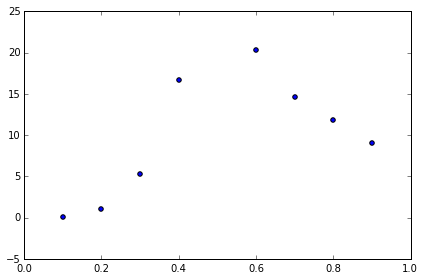

In [153]:
plt.scatter(tune_list,dH_list)

The next 2 plots show the particles with 1.e-6 and 1.e-5 values of H, respectively

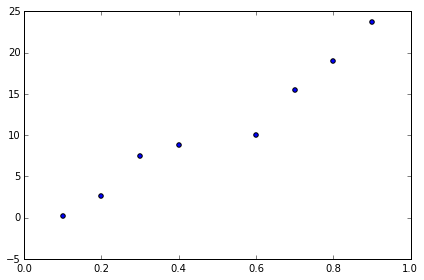

In [213]:
plt.scatter(tune_list,dH_list6)

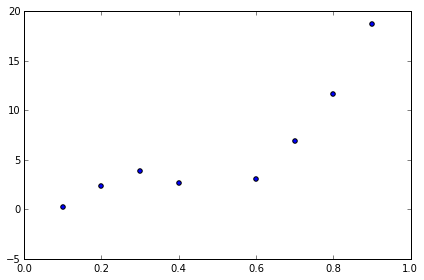

In [214]:
plt.scatter(tune_list,dH_list5)

In [156]:
x_test = np.linspace(0,0.5)
x_cubed = x_test**3

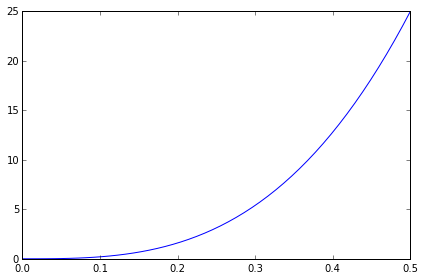

In [160]:
plt.scatter(tune_list,dH_list)
plt.plot(x_test,scalar*x_cubed)

In [203]:
scalar = 210
x2_test = np.linspace(0.6,1)
scalar2 = 10
scalar3 = 400
x2_vals = scalar3*(1-x2_test)**3 + scalar2*x2_test**5

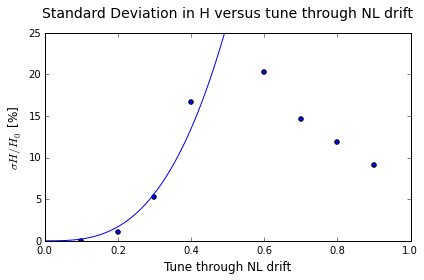

In [207]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(tune_list,dH_list)
ax.plot(x_test,scalar*x_cubed)
#ax.plot(x2_test,x2_vals)
plt.xlim([0,1.0])
plt.ylim([0,25])
plt.xlabel('Tune through NL drift',fontsize=12)
plt.ylabel('$\sigma H / H_0$ [%]',fontsize=12)
title = 'Standard Deviation in H versus tune through NL drift'
plt.title(title, y=1.05, fontsize=14)
sv_title = 'sigmaH_1e-7_vtune.pdf'
fig.savefig(sv_title, bbox_inches='tight')

###Initial Analysis

A quick test based on the toy scripts for the 0.1 and 0.2 tune cases.

In [118]:
simulations

{'0pt1_tune': {'R_matrix': array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ],
         [-0.63661002,  1.        ,  0.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.        , -0.63661002,  1.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
           3.2       ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           1.        ]]),
  'bunch': <synergia.bunch.bunch.Bunch at 0x113346af8>,
  'bunch_simulator': <synergia.simulation.simulation.Bunch_simulator at 0x113346b50>,
  'lattice': <synergia.lattice.lattice.Lattice at 0x113345ed8>,
  'lattice_simulator': <synergia.simulation.simulation.Lattice_simulator at 0x113303f30>,
  'opts': <synergia_workflow.options.Options instance at 0x113342878>,
  'outputdir

In [119]:
hstats = elliptic_sp.toy_analyze_invariant(opts1)

Particle 0:
mean H value: 2.59808605069e-05
std of H: 6.04186686894e-08
% variation of H: 0.232550683506%
Particle 1:
mean H value: 2.86943776987e-06
std of H: 4.15074736295e-09
% variation of H: 0.144653681168%
Particle 2:
mean H value: 2.82775526318e-07
std of H: 8.27732256727e-11
% variation of H: 0.0292717077572%


In [120]:
hstats2 = elliptic_sp.toy_analyze_invariant(opts2)

Particle 0:
mean H value: 6.34708106446e-05
std of H: 1.46812020341e-06
% variation of H: 2.31306357758%
Particle 1:
mean H value: 8.01736878967e-06
std of H: 2.08014488253e-07
% variation of H: 2.59454808317%
Particle 2:
mean H value: 8.26495904483e-07
std of H: 8.26627389559e-09
% variation of H: 1.00015908739%


In [117]:
s1 = simulations['0pt1_tune']
s2 = simulations['0pt2_tune']

firstBunch = s1['bunch']
secondBunch = s2['bunch']

opts1 = s1['opts']
opts2 = s2['opts']

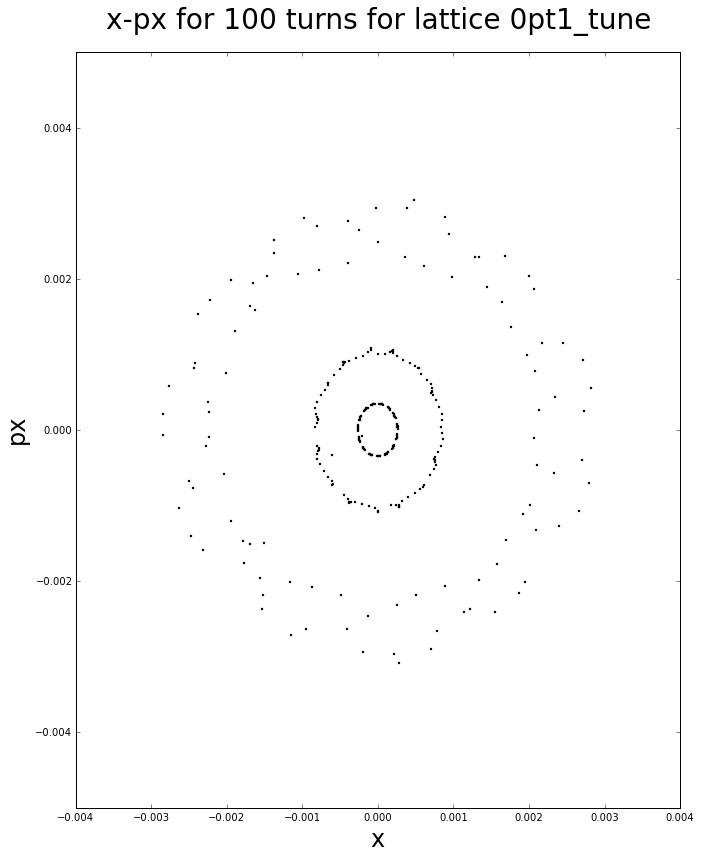

In [69]:
from base_diagnostics import options

s1 = simulations['0pt1_tune']
opts = s1['opts']
vals = s1['vals']

popts = options.Options()
popts.lattice_name = opts.name
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.5
#popts.lattice_simulator = opts.lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = opts.lattice
popts.alphae = opts.alphae
popts.betae = opts.betae

popts.plots = ['x','px']
popts.num = 3
popts.scale = 2
popts.plot_lost = False

elliptic_sp.toy_plot_Poincare(popts)

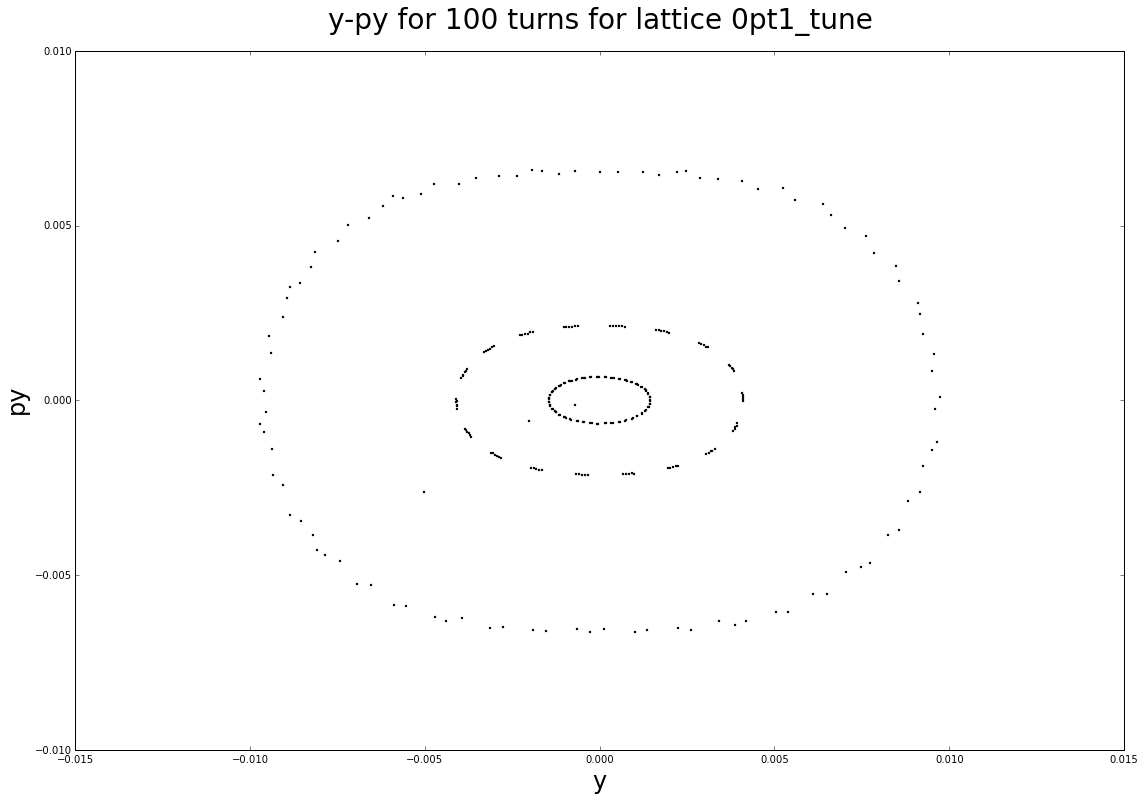

In [68]:
from base_diagnostics import options

s1 = simulations['0pt1_tune']
opts = s1['opts']
vals = s1['vals']

popts = options.Options()
popts.lattice_name = opts.name
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.5
#popts.lattice_simulator = opts.lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = opts.lattice
popts.alphae = opts.alphae
popts.betae = opts.betae

popts.plots = ['y','py']
popts.num = 3
popts.scale = 2
popts.plot_lost = False

elliptic_sp.toy_plot_Poincare(popts)

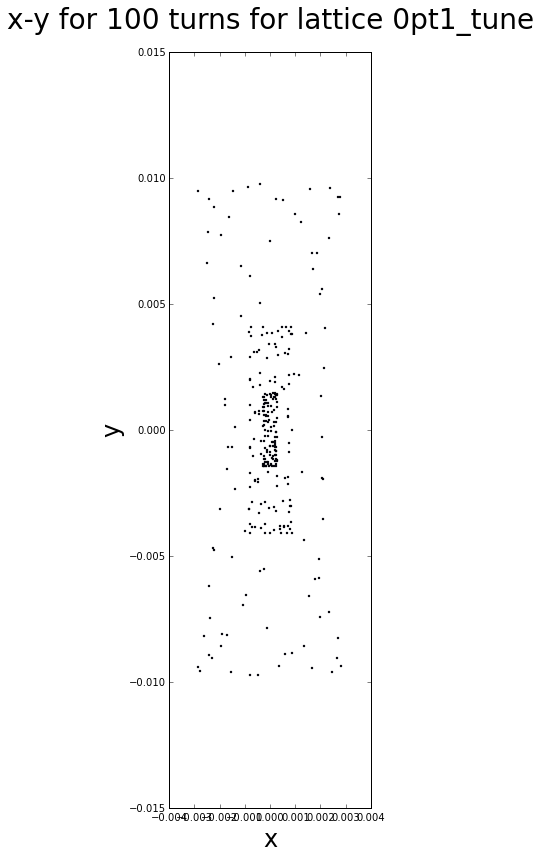

In [67]:
from base_diagnostics import options

s1 = simulations['0pt1_tune']
opts = s1['opts']
vals = s1['vals']

popts = options.Options()
popts.lattice_name = opts.name
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.5
#popts.lattice_simulator = opts.lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = opts.lattice
popts.alphae = opts.alphae
popts.betae = opts.betae

popts.plots = ['x','y']
popts.num = 3
popts.scale = 2
popts.plot_lost = False

elliptic_sp.toy_plot_Poincare(popts)

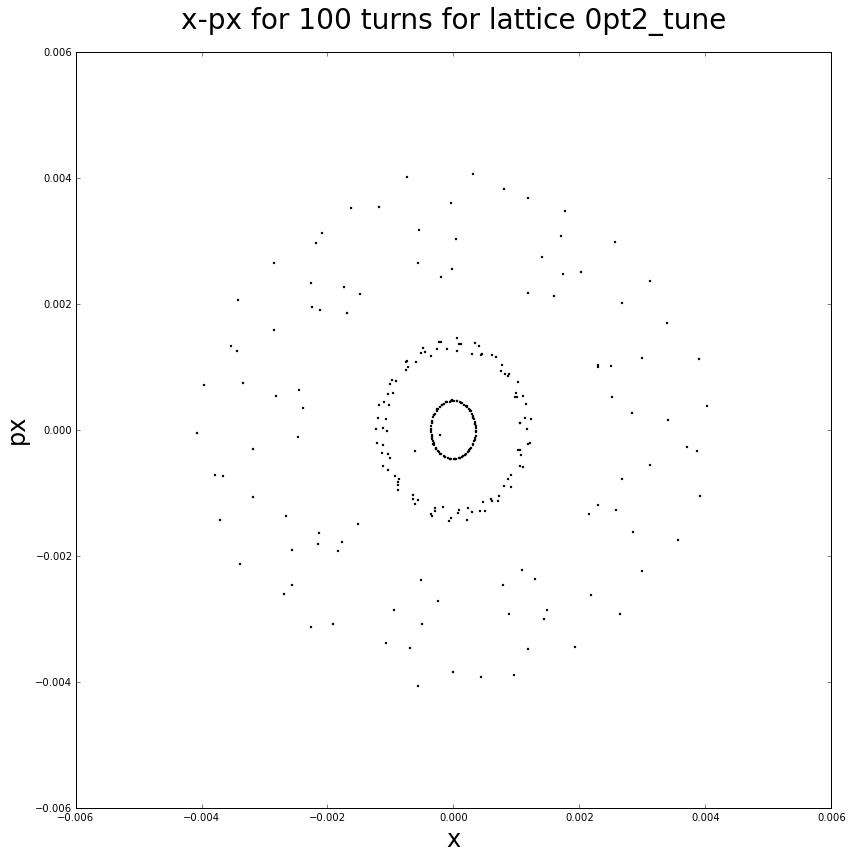

In [124]:
from base_diagnostics import options

opts = s2['opts']
vals = s2['vals']

popts = options.Options()
popts.lattice_name = opts.name
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.5
#popts.lattice_simulator = opts.lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = opts.lattice
popts.alphae = opts.alphae
popts.betae = opts.betae

popts.plots = ['x','px']
popts.num = 3
popts.scale = 2
popts.plot_lost = False

elliptic_sp.toy_plot_Poincare(popts)

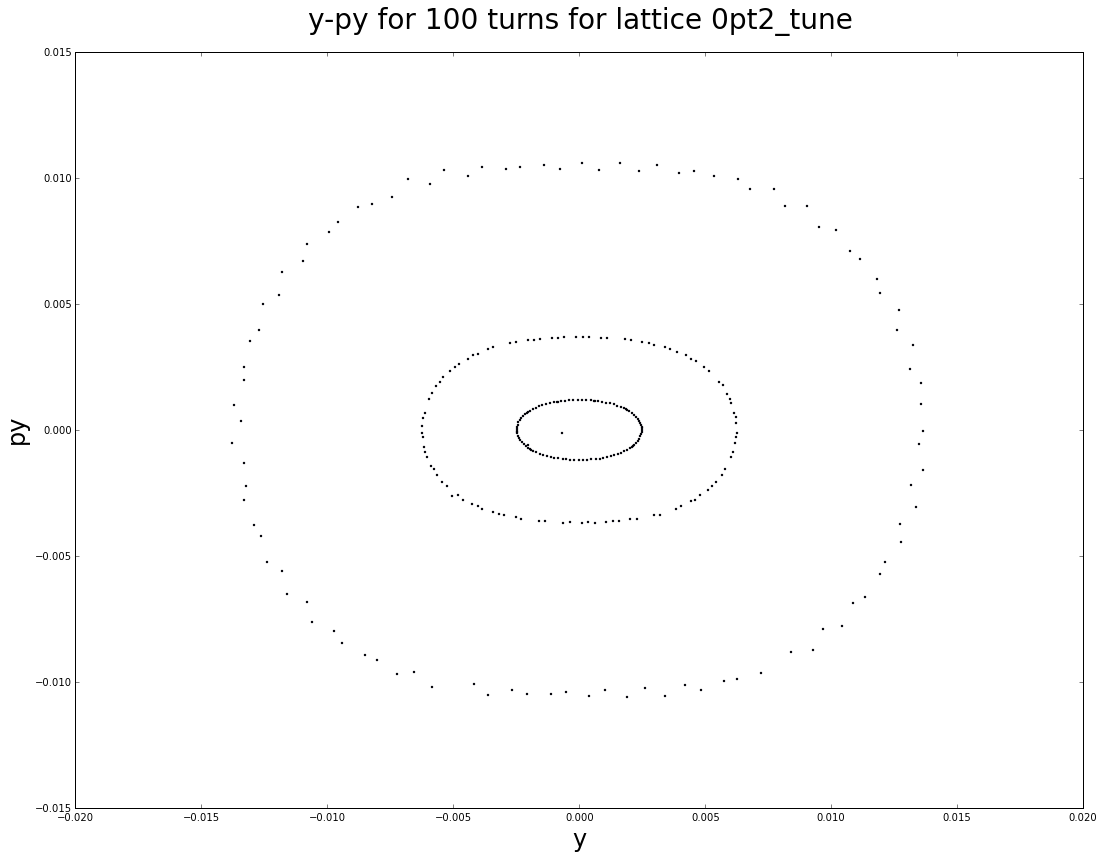

In [125]:
from base_diagnostics import options

opts = s2['opts']
vals = s2['vals']

popts = options.Options()
popts.lattice_name = opts.name
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.5
#popts.lattice_simulator = opts.lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = opts.lattice
popts.alphae = opts.alphae
popts.betae = opts.betae

popts.plots = ['y','py']
popts.num = 3
popts.scale = 2
popts.plot_lost = False

elliptic_sp.toy_plot_Poincare(popts)

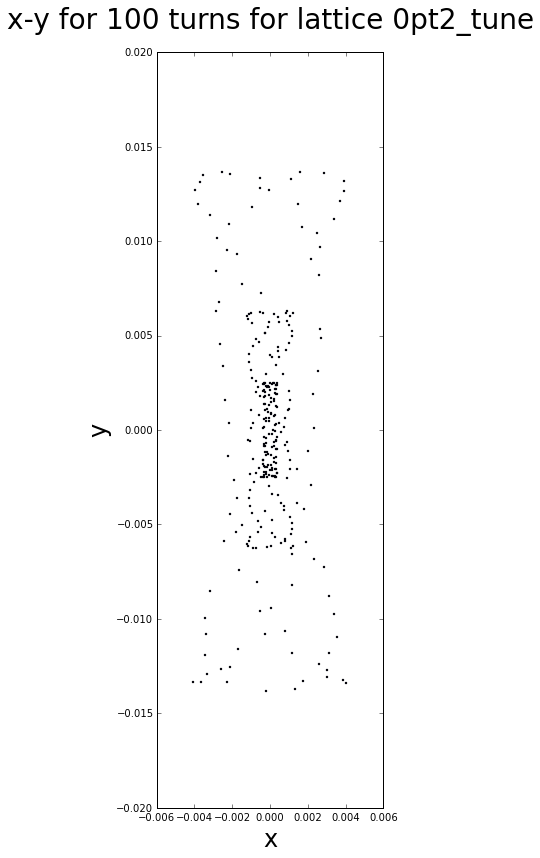

In [126]:
from base_diagnostics import options

opts = s2['opts']
vals = s2['vals']

popts = options.Options()
popts.lattice_name = opts.name
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.5
#popts.lattice_simulator = opts.lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = opts.lattice
popts.alphae = opts.alphae
popts.betae = opts.betae

popts.plots = ['x','y']
popts.num = 3
popts.scale = 2
popts.plot_lost = False

elliptic_sp.toy_plot_Poincare(popts)

##Script development and testing

In [58]:
hAfter = hArray[1::]
h1s = hAfter[:,0]
h2s = hAfter[:,1]
h3s = hAfter[:,2]

In [59]:
h_mean = np.mean(h1s)
h_std = np.std(h1s)
print (h_std/h_mean)*100.

0.232550683506


In [60]:
h_mean = np.mean(h2s)
h_std = np.std(h2s)
print (h_std/h_mean)*100.

0.144653681168


In [61]:
h_mean = np.mean(h3s)
h_std = np.std(h3s)
print (h_std/h_mean)*100.

0.0292717077572


In [15]:
#construct the R-matrix
opts.new_tune = tune
opts.lnll = lattice.get_length()
opts.nseg = 40
opts.t = 0.4
opts.c = 0.01
vals = get_base_nll(opts.nseg, opts.lnll, opts.new_tune, opts.t, opts.c)

opts.f0 = vals[0]
opts.betae = vals[1]
opts.alphae = vals[2]
opts.beta0 = vals[3]

In [25]:
opts.emits = [1.0e-5, 1.0e-6, 1.0e-7]

In [100]:
type(trialBunch)

list

In [119]:
trialBunch2 = EllipticBeam6D.toyEllipticalBeam6D(opts)
initialH = elliptic_sp.calc_bunch_H(trialBunch2,opts)


    
print "Constructed trial bunch with " + str(len(trialBunch2)) + " particles."
print
print "Single particle emittances are:"
print
for num in range(len(trialBunch2)):
    print "Particle " + str(num) + ": " + str(initialH[num])
    variation = np.abs(initialH[num]- opts.emits[num])/initialH[num]
    tol = 1.e-2
    if  variation > tol:
        print "Warning. Particle Hamiltonians differ from target value by more than " + str(tol*100) + "%"

Constructed trial bunch with 3 particles.

Single particle emittances are:

Particle 0: 1.00170268211e-05
Particle 1: 1.00045733521e-06
Particle 2: 1.00006201733e-07


In [105]:
type(trialBunch2)

numpy.ndarray

In [81]:
trialBunch = EllipticBeam6D.toyEllipticalBeam6D(opts)
particles = []
p1 = []
for arr in trialBunch:
    p1.append(arr[0])
particles = np.asarray(p1)

In [110]:
from base_diagnostics import elliptic_sp
initialH = elliptic_sp.calc_bunch_H(trialBunch2,opts)

In [111]:
testH

array([  1.00170268e-05,   1.00045734e-06,   1.00006202e-07])

In [22]:
EllipticBeam6D.toyEllipticalBeam6D(opts)

[array([-0.00133461, -0.00162111, -0.00445802, -0.00352385])]

In [23]:
EllipticBeam6D.toyEllipticalBeam6D(opts)

[array([-0.00133461, -0.00162111, -0.00445802, -0.00352385])]

In [53]:
opts.lattice = lattice
from base_diagnostics import elliptic_sp
twiss = elliptic_sp.get_toy_twiss(opts)

In [95]:
header= {}
header['s_val'] = 0
norm_coords = elliptic_sp.normalized_coordinates(header, particles, twiss)
u,v = elliptic_sp.elliptic_coordinates(norm_coords, opts)

In [85]:
norm_coords

array([[-0.00150769, -0.00247622, -0.00503615, -0.00590565],
       [-0.00060895, -0.0007314 , -0.00203408, -0.00191244],
       [-0.0002089 , -0.00021145, -0.0006978 , -0.00058664]])

In [96]:
norm_coords

array([[ -1.50768822e-03,  -1.49646375e-03,  -5.03615451e-03,
         -2.63296032e-03],
       [ -6.08949667e-04,  -3.35680322e-04,  -2.03408408e-03,
         -5.90614351e-04],
       [ -2.08903063e-04,  -7.56927582e-05,  -6.97802162e-04,
         -1.33177986e-04]])

In [97]:
hArray = elliptic_sp.single_particle_hamiltonian(norm_coords) + elliptic_sp.elliptic_hamiltonian(u,v,opts)  

In [98]:
hArray

array([  1.00170268e-05,   1.00045734e-06,   1.00006202e-07])

In [92]:
iArray = elliptic_sp.second_invariant(norm_coords,u,v,opts)

In [94]:
hArray

array([  2.59352773e-05,   2.86589468e-06,   2.82699736e-07])

In [ ]:

#t2 = twiss[:-1,:]
#twiss = get_twiss(opts.lattice_simulator)

lost = None
hArray = get_single_particle_elliptic_invariants(files, twiss, opts, lost, 1)
iArray = get_single_particle_elliptic_invariants(files, twiss, opts, lost, 2)

In [ ]:
particles = 
norm_coords = normalized_coordinates(header, particles, twiss)
#construct elliptic coordinates for that file
u,v = elliptic_coordinates(norm_coords, opts)

In [54]:
twiss[0]

array([ 0.        ,  1.02078097,  0.3249197 ,  1.08306565,  1.02078097,
        0.3249197 ,  1.08306565])

In [55]:
opts1.betae

1.0207809700224479

In [ ]:
h